In [1]:
import pandas as pd

In [41]:
import warnings
warnings.filterwarnings("ignore")

Here we take a subsample of the store data from Kaggle 

In [2]:
train_df = pd.read_csv("data/store/subset.csv")

In [3]:
train_df['store_nbr'].value_counts()

1     5052
10    5052
2     5052
3     5052
4     5052
5     5052
6     5052
7     5052
8     5052
9     5052
Name: store_nbr, dtype: int64

In [4]:
train_df['family'].value_counts()

BEAUTY      16840
CLEANING    16840
PRODUCE     16840
Name: family, dtype: int64

This data set has 10 * 3 = 30 time series.

### Building an ARIMA model 

In [36]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

Because ARIMA models are univariate models, we need to build each model for each time series separately (30 models). Here we just build a model on one of the time series 

In [113]:
sample_ts = train_df[(train_df['store_nbr'] == 1) & (train_df['family'] == 'BEAUTY')]
sample_ts = sample_ts.reset_index()[-300:]

Let's first visualize this time series

In [25]:
import seaborn as sns

In [114]:
sample_ts['date'] = pd.to_datetime(sample_ts['date'])

<AxesSubplot:xlabel='date', ylabel='sales'>

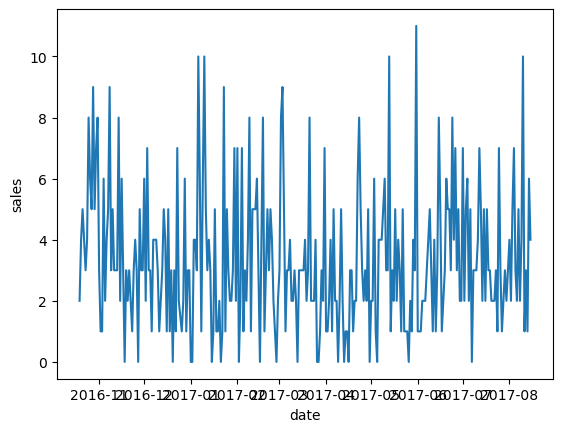

In [115]:
sns.lineplot(x='date', y='sales', data=sample_ts)

split the data into train and valid dataset

In [135]:
train_ts = sample_ts[:int(0.9 * len(sample_ts))]
valid_ts = sample_ts[int(0.9 * len(sample_ts)): ]

Model training - let's choose some p, d, q to start with

In [155]:
model = ARIMA(train_ts['sales'], order=(5, 1, 5))
model_fit = model.fit()
predictions = model_fit.get_prediction(start=len(train_ts) + 1, end=len(sample_ts))


plot the model training result -- we will plot both the confidence interval and mean of the predictions

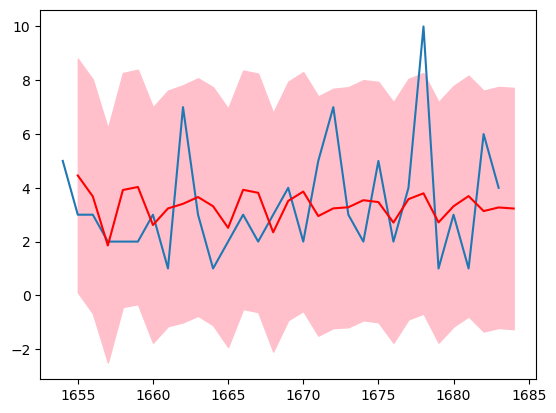

In [156]:
pred_conf = predictions.conf_int()
plt.plot(valid_ts['sales'], label='Observed')
plt.plot(predictions.predicted_mean, label='Predicted', color='r')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink')

Evaluate the models using root mean squared error

In [118]:
from sklearn.metrics import mean_squared_error


In [119]:
np.sqrt(mean_squared_error(valid_ts['sales'], predictions.predicted_mean))

2.113897429820731

Since this model is not in Scikit-learn, we cannot use Scikit-learn's grid search function. Let's create our own grid search function to find the best p, d, q

In [121]:
def train_and_get_error(p, d, q):
    model = ARIMA(train_ts['sales'], order=(p, d, q))
    model_fit = model.fit()
    predictions = model_fit.get_prediction(start=len(train_ts) + 1, end=len(sample_ts))
    mean_prediction = predictions.predicted_mean
    return np.sqrt(mean_squared_error(valid_ts['sales'], predictions.predicted_mean))

In [148]:
ps = [3, 5, 7, 9]
ds = [1, 2, 3]
qs = [3, 5, 7, 9]

In [157]:
minimum_loss = 99
best_params = None

for p in ps:
    for d in ds:
        for q in qs:
           
            loss = train_and_get_error(p, d, q)
            if loss < minimum_loss:
                minimum_loss = loss
                best_params = (p, d, q)

In [158]:
best_params

(3, 3, 3)

We need to repeat this process for ALL 30 time series. Homework: write a python functionn to perform the above process (train ARIMA model and find the best hyperparameter) for any time series, and run the function on the other 29 time series 